# HDB Multi-storey Carparks

Carparks are essential facilities and many are sprawled across the entire Singapore, especially close to the HDB apartments. Due to the land scarcity, a lot of carparks are constructed with multiple-storeys 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('magma')

In [2]:
hdb = pd.read_csv('Datasets/hdb-carpark-information.csv')

In [3]:
hdb.head()

car_park_no                                      address     x_coord  \
0         ACB  BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936   
1         ACM                    BLK 98A ALJUNIED CRESCENT  33758.4143   
2         AH1                          BLK 101 JALAN DUSUN  29257.7203   
3        AK19               BLOCK 253 ANG MO KIO STREET 21  28185.4359   
4        AK31                 BLK 302/348 ANG MO KIO ST 31  29482.0290   

      y_coord          car_park_type type_of_parking_system  \
0  31490.4942      BASEMENT CAR PARK     ELECTRONIC PARKING   
1  33695.5198  MULTI-STOREY CAR PARK     ELECTRONIC PARKING   
2  34500.3599       SURFACE CAR PARK     ELECTRONIC PARKING   
3  39012.6664       SURFACE CAR PARK         COUPON PARKING   
4  38684.1754       SURFACE CAR PARK         COUPON PARKING   

  short_term_parking             free_parking night_parking  car_park_decks  \
0          WHOLE DAY                       NO           YES               1   
1          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES               5   
2          WHOLE DAY  SUN & PH FR 7AM-10.30PM           YES               0   
3            7AM-7PM                       NO            NO               0   
4                 NO                       NO            NO               0   

   gantry_height car_park_basement  car_park_lots  
0            1.8                 Y           82.0  
1            2.1                 N          315.0  
2            0.0                 N          268.0  
3            0.0                 N            NaN  
4            0.0                 N            NaN

In [4]:
hdb.drop(['car_park_no'], axis = 1, inplace = True)

In [5]:
hdb.columns = hdb.columns.str.replace(' ', '_')

In [6]:
hdb = hdb.set_index('address', drop=True)

In [7]:
hdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2165 entries, BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK to BLK 747/752 YISHUN STREET 72
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   x_coord                 2165 non-null   float64
 1   y_coord                 2165 non-null   float64
 2   car_park_type           2165 non-null   object 
 3   type_of_parking_system  2165 non-null   object 
 4   short_term_parking      2165 non-null   object 
 5   free_parking            2165 non-null   object 
 6   night_parking           2165 non-null   object 
 7   car_park_decks          2165 non-null   int64  
 8   gantry_height           2165 non-null   float64
 9   car_park_basement       2165 non-null   object 
 10  car_park_lots           859 non-null    float64
dtypes: float64(4), int64(1), object(6)
memory usage: 203.0+ KB


In [8]:
hdb['night_parking'].unique()

array(['YES', 'NO'], dtype=object)

In [9]:
hdb['night_parking'] = hdb['night_parking'].map({'YES':1, 'NO':0})
hdb['night_parking'].unique()

array([1, 0])

In [10]:
hdb['car_park_basement'].unique()

array(['Y', 'N'], dtype=object)

In [11]:
hdb['car_park_basement'] = hdb['car_park_basement'].map({'Y':1, 'N':0})
hdb['car_park_basement'].unique()

array([1, 0])

In [12]:
hdb.replace(' ', '_', regex = True, inplace = True)
hdb.head()

x_coord     y_coord  \
address                                                               
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936  31490.4942   
BLK 98A ALJUNIED CRESCENT                    33758.4143  33695.5198   
BLK 101 JALAN DUSUN                          29257.7203  34500.3599   
BLOCK 253 ANG MO KIO STREET 21               28185.4359  39012.6664   
BLK 302/348 ANG MO KIO ST 31                 29482.0290  38684.1754   

                                                     car_park_type  \
address                                                              
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK      BASEMENT_CAR_PARK   
BLK 98A ALJUNIED CRESCENT                    MULTI-STOREY_CAR_PARK   
BLK 101 JALAN DUSUN                               SURFACE_CAR_PARK   
BLOCK 253 ANG MO KIO STREET 21                    SURFACE_CAR_PARK   
BLK 302/348 ANG MO KIO ST 31                      SURFACE_CAR_PARK   

                                            type_of_parking_system  \
address                                                              
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK     ELECTRONIC_PARKING   
BLK 98A ALJUNIED CRESCENT                       ELECTRONIC_PARKING   
BLK 101 JALAN DUSUN                             ELECTRONIC_PARKING   
BLOCK 253 ANG MO KIO STREET 21                      COUPON_PARKING   
BLK 302/348 ANG MO KIO ST 31                        COUPON_PARKING   

                                            short_term_parking  \
address                                                          
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK          WHOLE_DAY   
BLK 98A ALJUNIED CRESCENT                            WHOLE_DAY   
BLK 101 JALAN DUSUN                                  WHOLE_DAY   
BLOCK 253 ANG MO KIO STREET 21                         7AM-7PM   
BLK 302/348 ANG MO KIO ST 31                                NO   

                                                        free_parking  \
address                                                                
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK                       NO   
BLK 98A ALJUNIED CRESCENT                    SUN_&_PH_FR_7AM-10.30PM   
BLK 101 JALAN DUSUN                          SUN_&_PH_FR_7AM-10.30PM   
BLOCK 253 ANG MO KIO STREET 21                                    NO   
BLK 302/348 ANG MO KIO ST 31                                      NO   

                                             night_parking  car_park_decks  \
address                                                                      
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK              1               1   
BLK 98A ALJUNIED CRESCENT                                1               5   
BLK 101 JALAN DUSUN                                      1               0   
BLOCK 253 ANG MO KIO STREET 21                           0               0   
BLK 302/348 ANG MO KIO ST 31                             0               0   

                                             gantry_height  car_park_basement  \
address                                                                         
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK            1.8                  1   
BLK 98A ALJUNIED CRESCENT                              2.1                  0   
BLK 101 JALAN DUSUN                                    0.0                  0   
BLOCK 253 ANG MO KIO STREET 21                         0.0                  0   
BLK 302/348 ANG MO KIO ST 31                           0.0                  0   

                                             car_park_lots  
address                                                     
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK           82.0  
BLK 98A ALJUNIED CRESCENT                            315.0  
BLK 101 JALAN DUSUN                                  268.0  
BLOCK 253 ANG MO KIO STREET 21                         NaN  
BLK 302/348 ANG MO KIO ST 31                           NaN

In [13]:
hdb['type_of_parking_system'].value_counts()

ELECTRONIC_PARKING    1975
COUPON_PARKING         190
Name: type_of_parking_system, dtype: int64

In [14]:
hdb['car_park_type'].value_counts()

SURFACE_CAR_PARK                   1089
MULTI-STOREY_CAR_PARK              1018
BASEMENT_CAR_PARK                    34
SURFACE/MULTI-STOREY_CAR_PARK        12
COVERED_CAR_PARK                      9
MECHANISED_AND_SURFACE_CAR_PARK       2
MECHANISED_CAR_PARK                   1
Name: car_park_type, dtype: int64

In [15]:
hdb.car_park_type = hdb.car_park_type.map({'SURFACE_CAR_PARK': 'SURFACE_CAR_PARK',
                                           'MULTI-STOREY_CAR_PARK': 'MULTI-STOREY_CAR_PARK',
                                           'BASEMENT_CAR_PARK': 'OTHERS',
                                           'SURFACE/MULTI-STOREY_CAR_PARK': 'OTHERS',
                                           'COVERED_CAR_PARK': 'OTHERS',
                                           'MECHANISED_AND_SURFACE_CAR_PARK': 'OTHERS',
                                           'MECHANISED_CAR_PARK': 'OTHERS'})

In [16]:
hdb['car_park_type'].value_counts()

SURFACE_CAR_PARK         1089
MULTI-STOREY_CAR_PARK    1018
OTHERS                     58
Name: car_park_type, dtype: int64

In [17]:
hdb1 = pd.get_dummies(hdb, columns = ['car_park_type', 'type_of_parking_system', 'short_term_parking', 'free_parking'])

In [18]:
hdb1.head()

x_coord     y_coord  \
address                                                               
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936  31490.4942   
BLK 98A ALJUNIED CRESCENT                    33758.4143  33695.5198   
BLK 101 JALAN DUSUN                          29257.7203  34500.3599   
BLOCK 253 ANG MO KIO STREET 21               28185.4359  39012.6664   
BLK 302/348 ANG MO KIO ST 31                 29482.0290  38684.1754   

                                             night_parking  car_park_decks  \
address                                                                      
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK              1               1   
BLK 98A ALJUNIED CRESCENT                                1               5   
BLK 101 JALAN DUSUN                                      1               0   
BLOCK 253 ANG MO KIO STREET 21                           0               0   
BLK 302/348 ANG MO KIO ST 31                             0               0   

                                             gantry_height  car_park_basement  \
address                                                                         
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK            1.8                  1   
BLK 98A ALJUNIED CRESCENT                              2.1                  0   
BLK 101 JALAN DUSUN                                    0.0                  0   
BLOCK 253 ANG MO KIO STREET 21                         0.0                  0   
BLK 302/348 ANG MO KIO ST 31                           0.0                  0   

                                             car_park_lots  \
address                                                      
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK           82.0   
BLK 98A ALJUNIED CRESCENT                            315.0   
BLK 101 JALAN DUSUN                                  268.0   
BLOCK 253 ANG MO KIO STREET 21                         NaN   
BLK 302/348 ANG MO KIO ST 31                           NaN   

                                             car_park_type_MULTI-STOREY_CAR_PARK  \
address                                                                            
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK                                    0   
BLK 98A ALJUNIED CRESCENT                                                      1   
BLK 101 JALAN DUSUN                                                            0   
BLOCK 253 ANG MO KIO STREET 21                                                 0   
BLK 302/348 ANG MO KIO ST 31                                                   0   

                                             car_park_type_OTHERS  \
address                                                             
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK                     1   
BLK 98A ALJUNIED CRESCENT                                       0   
BLK 101 JALAN DUSUN                                             0   
BLOCK 253 ANG MO KIO STREET 21                                  0   
BLK 302/348 ANG MO KIO ST 31                                    0   

                                             car_park_type_SURFACE_CAR_PARK  \
address                                                                       
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK                               0   
BLK 98A ALJUNIED CRESCENT                                                 0   
BLK 101 JALAN DUSUN                                                       1   
BLOCK 253 ANG MO KIO STREET 21                                            1   
BLK 302/348 ANG MO KIO ST 31                                              1   

                                             type_of_parking_system_COUPON_PARKING  \
address                                                                              
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK                                      0   
BLK 98A ALJUNIED CRESCENT                                                        0   
BLK 101 JALAN DUSUN          

<AxesSubplot:>

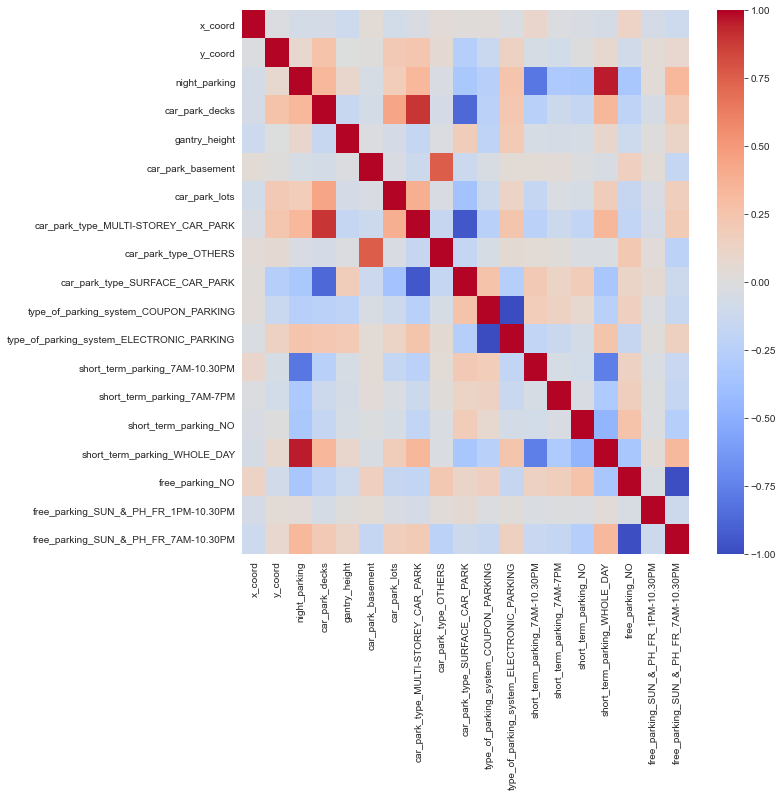

In [19]:
plt.figure(figsize = (10,10))
sns.heatmap(hdb1.corr(), cmap = 'coolwarm')

In [20]:
hdb1.corr()['car_park_lots'].sort_values()

car_park_type_SURFACE_CAR_PARK              -0.374543
short_term_parking_7AM-10.30PM              -0.168417
free_parking_NO                             -0.162477
type_of_parking_system_COUPON_PARKING       -0.120536
x_coord                                     -0.079289
gantry_height                               -0.066990
short_term_parking_NO                       -0.049313
car_park_basement                           -0.035031
free_parking_SUN_&_PH_FR_1PM-10.30PM        -0.034846
car_park_type_OTHERS                        -0.032696
short_term_parking_7AM-7PM                  -0.026518
type_of_parking_system_ELECTRONIC_PARKING    0.120536
free_parking_SUN_&_PH_FR_7AM-10.30PM         0.168036
short_term_parking_WHOLE_DAY                 0.178811
night_parking                                0.180502
y_coord                                      0.212653
car_park_type_MULTI-STOREY_CAR_PARK          0.383547
car_park_decks                               0.438036
car_park_lots               

## KNN Imputation

In [21]:
knn_imp = KNNImputer(n_neighbors = 5)
knn_imp_parking_missing = knn_imp.fit_transform(hdb1)

hdb_imputed = pd.DataFrame(knn_imp_parking_missing, columns = hdb1.columns)

In [22]:
hdb_imputed

x_coord     y_coord  night_parking  car_park_decks  gantry_height  \
0     30314.7936  31490.4942            1.0             1.0           1.80   
1     33758.4143  33695.5198            1.0             5.0           2.10   
2     29257.7203  34500.3599            1.0             0.0           0.00   
3     28185.4359  39012.6664            0.0             0.0           0.00   
4     29482.0290  38684.1754            0.0             0.0           0.00   
...          ...         ...            ...             ...            ...   
2160  29850.1522  45576.0125            1.0            10.0           2.15   
2161  30057.2209  45166.4820            1.0             4.0           2.15   
2162  27772.9219  45686.2734            1.0             0.0           4.50   
2163  29935.5818  45679.7181            1.0            11.0           2.15   
2164  28077.2305  45507.8047            1.0             0.0           4.50   

      car_park_basement  car_park_lots  car_park_type_MULTI-STOREY_CAR_PARK  \
0                   1.0           82.0                                  0.0   
1                   0.0          315.0                                  1.0   
2                   0.0          268.0                                  0.0   
3                   0.0          117.6                                  0.0   
4                   0.0          373.4                                  0.0   
...                 ...            ...                                  ...   
2160                0.0          413.0                                  1.0   
2161                0.0          372.6                                  1.0   
2162                0.0          697.0                                  0.0   
2163                0.0          413.0                                  1.0   
2164                0.0          262.0                                  0.0   

      car_park_type_OTHERS  car_park_type_SURFACE_CAR_PARK  \
0                      1.0                             0.0   
1                      0.0                             0.0   
2                      0.0                             1.0   
3                      0.0                             1.0   
4                      0.0                             1.0   
...                    ...                             ...   
2160                   0.0                             0.0   
2161                   0.0                             0.0   
2162                   0.0                             1.0   
2163                   0.0                             0.0   
2164                   0.0                             1.0   

      type_of_parking_system_COUPON_PARKING  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       1.0   
4                                       1.0   
...                                     ...   
2160                                    0.0   
2161                                    0.0   
2162                                    0.0   
2163                                    0.0   
2164                                    0.0   

      type_of_parking_system_ELECTRONIC_PARKING  \
0                                           1.0   
1                                           1.0   
2                                           1.0   
3                                           0.0   
4                                           0.0   
...                                         ...   
2160                                        1.0   
2161                                        1.0   
2162                                        1.0   
2163                                        1.0   
2164                                        1.0   

      short_term_parking_7AM-10.30PM  short_term_parking_7AM-7PM  \
0                                0.0                         0.0   
1                                0.0                         0.0

In [23]:
hdb_imputed['car_park_lots'] = hdb_imputed['car_park_lots'].apply(np.ceil)

In [24]:
hdb_imputed

x_coord     y_coord  night_parking  car_park_decks  gantry_height  \
0     30314.7936  31490.4942            1.0             1.0           1.80   
1     33758.4143  33695.5198            1.0             5.0           2.10   
2     29257.7203  34500.3599            1.0             0.0           0.00   
3     28185.4359  39012.6664            0.0             0.0           0.00   
4     29482.0290  38684.1754            0.0             0.0           0.00   
...          ...         ...            ...             ...            ...   
2160  29850.1522  45576.0125            1.0            10.0           2.15   
2161  30057.2209  45166.4820            1.0             4.0           2.15   
2162  27772.9219  45686.2734            1.0             0.0           4.50   
2163  29935.5818  45679.7181            1.0            11.0           2.15   
2164  28077.2305  45507.8047            1.0             0.0           4.50   

      car_park_basement  car_park_lots  car_park_type_MULTI-STOREY_CAR_PARK  \
0                   1.0           82.0                                  0.0   
1                   0.0          315.0                                  1.0   
2                   0.0          268.0                                  0.0   
3                   0.0          118.0                                  0.0   
4                   0.0          374.0                                  0.0   
...                 ...            ...                                  ...   
2160                0.0          413.0                                  1.0   
2161                0.0          373.0                                  1.0   
2162                0.0          697.0                                  0.0   
2163                0.0          413.0                                  1.0   
2164                0.0          262.0                                  0.0   

      car_park_type_OTHERS  car_park_type_SURFACE_CAR_PARK  \
0                      1.0                             0.0   
1                      0.0                             0.0   
2                      0.0                             1.0   
3                      0.0                             1.0   
4                      0.0                             1.0   
...                    ...                             ...   
2160                   0.0                             0.0   
2161                   0.0                             0.0   
2162                   0.0                             1.0   
2163                   0.0                             0.0   
2164                   0.0                             1.0   

      type_of_parking_system_COUPON_PARKING  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       1.0   
4                                       1.0   
...                                     ...   
2160                                    0.0   
2161                                    0.0   
2162                                    0.0   
2163                                    0.0   
2164                                    0.0   

      type_of_parking_system_ELECTRONIC_PARKING  \
0                                           1.0   
1                                           1.0   
2                                           1.0   
3                                           0.0   
4                                           0.0   
...                                         ...   
2160                                        1.0   
2161                                        1.0   
2162                                        1.0   
2163                                        1.0   
2164                                        1.0   

      short_term_parking_7AM-10.30PM  short_term_parking_7AM-7PM  \
0                                0.0                         0.0   
1                                0.0                         0.0

In [25]:
hdb['car_park_lots'] = hdb_imputed['car_park_lots'].values

In [26]:
hdb.head()

x_coord     y_coord  \
address                                                               
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936  31490.4942   
BLK 98A ALJUNIED CRESCENT                    33758.4143  33695.5198   
BLK 101 JALAN DUSUN                          29257.7203  34500.3599   
BLOCK 253 ANG MO KIO STREET 21               28185.4359  39012.6664   
BLK 302/348 ANG MO KIO ST 31                 29482.0290  38684.1754   

                                                     car_park_type  \
address                                                              
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK                 OTHERS   
BLK 98A ALJUNIED CRESCENT                    MULTI-STOREY_CAR_PARK   
BLK 101 JALAN DUSUN                               SURFACE_CAR_PARK   
BLOCK 253 ANG MO KIO STREET 21                    SURFACE_CAR_PARK   
BLK 302/348 ANG MO KIO ST 31                      SURFACE_CAR_PARK   

                                            type_of_parking_system  \
address                                                              
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK     ELECTRONIC_PARKING   
BLK 98A ALJUNIED CRESCENT                       ELECTRONIC_PARKING   
BLK 101 JALAN DUSUN                             ELECTRONIC_PARKING   
BLOCK 253 ANG MO KIO STREET 21                      COUPON_PARKING   
BLK 302/348 ANG MO KIO ST 31                        COUPON_PARKING   

                                            short_term_parking  \
address                                                          
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK          WHOLE_DAY   
BLK 98A ALJUNIED CRESCENT                            WHOLE_DAY   
BLK 101 JALAN DUSUN                                  WHOLE_DAY   
BLOCK 253 ANG MO KIO STREET 21                         7AM-7PM   
BLK 302/348 ANG MO KIO ST 31                                NO   

                                                        free_parking  \
address                                                                
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK                       NO   
BLK 98A ALJUNIED CRESCENT                    SUN_&_PH_FR_7AM-10.30PM   
BLK 101 JALAN DUSUN                          SUN_&_PH_FR_7AM-10.30PM   
BLOCK 253 ANG MO KIO STREET 21                                    NO   
BLK 302/348 ANG MO KIO ST 31                                      NO   

                                             night_parking  car_park_decks  \
address                                                                      
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK              1               1   
BLK 98A ALJUNIED CRESCENT                                1               5   
BLK 101 JALAN DUSUN                                      1               0   
BLOCK 253 ANG MO KIO STREET 21                           0               0   
BLK 302/348 ANG MO KIO ST 31                             0               0   

                                             gantry_height  car_park_basement  \
address                                                                         
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK            1.8                  1   
BLK 98A ALJUNIED CRESCENT                              2.1                  0   
BLK 101 JALAN DUSUN                                    0.0                  0   
BLOCK 253 ANG MO KIO STREET 21                         0.0                  0   
BLK 302/348 ANG MO KIO ST 31                           0.0                  0   

                                             car_park_lots  
address                                                     
BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK           82.0  
BLK 98A ALJUNIED CRESCENT                            315.0  
BLK 101 JALAN DUSUN                                  268.0  
BLOCK 253 ANG MO KIO STREET 21                       118.0  
BLK 302/348 ANG MO KIO ST 31                         374.0

Text(0, 0.5, 'Count')

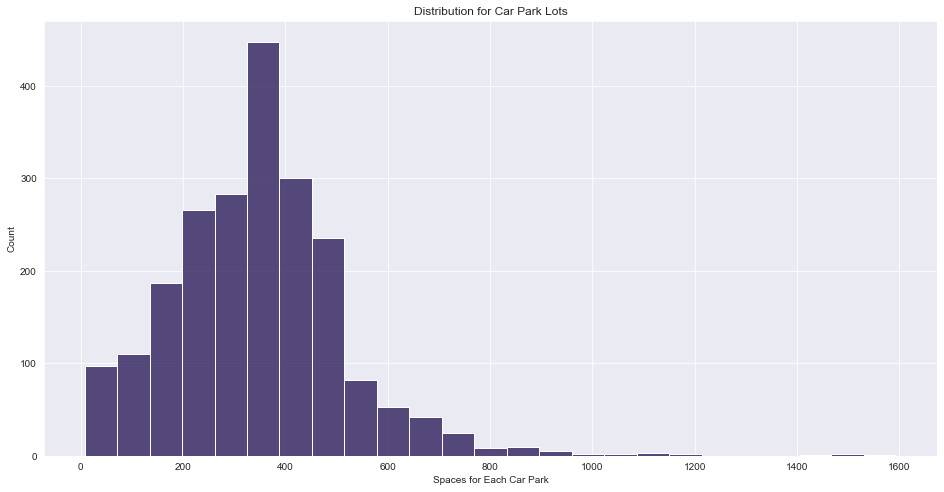

In [27]:
plt.figure(figsize = (16,8))
sns.histplot(hdb.car_park_lots, bins = 25)
plt.title('Distribution for Car Park Lots')
plt.xlabel('Spaces for Each Car Park')
plt.ylabel('Count')

In [28]:
hdb.to_csv('Datasets/hdb_parking_cleaned.csv')